<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

## Quantum Volume
---

* **Last Updated:** August 6, 2019
* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2


## Introduction

**Quantum Volume (QV)** is a method to verify device performance and a metric to quantify the computational power of a quantum device.  The method is based on the paper "Validating quantum computers using randomized model circuits" (arxiv.org/abs/1811.12926). 

This notebook gives an example for how to use the ``ignis.verification.quantum_volume`` module. This particular example shows how to run up to depth 6 quantum volume circuits and will run them using the noisy Aer simulator.

In [25]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the qv function.
import qiskit.ignis.verification.quantum_volume as qv

## Select the Parameters of the QV Run

In this example we have 6 qubits Q0,Q1,Q3,Q5,Q7,Q10. We are going to look at subsets up to the full set.

In [26]:
# Qubit list
qubit_lists = [[0,1,3],[0,1,3,5],[0,1,3,5,7],[0,1,3,5,7,10]]
ntrials = 5    # the mini-version AKA when it's 4AM and you are tired, but in haste; default value is 50

## Generate QV sequences

We generate the quantum volume sequences. We start with a small example (so it doesn't take too long to run).


In [27]:
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

In [28]:
# Pass the first trial of the nomeas through the transpiler to illustrate the circuit
qv_circs_nomeas[0] = qiskit.compiler.transpile(qv_circs_nomeas[0], basis_gates=['u1','u2','u3','cx'])

As an example, we print the circuit corresponding to the first QV sequence. Note that the ideal circuits are run on the first n qubits (where n is the number of qubits in the subset).

In [29]:
print(qv_circs_nomeas[0][0])

          ┌──────────────────────────┐┌───┐ ┌─────────────────────┐  ┌───┐»
qr_0: |0>─┤ U3(2.8746,-2.943,2.1446) ├┤ X ├─┤ U3(pi/2,-pi,2.8411) ├──┤ X ├»
         ┌┴──────────────────────────┤└─┬─┘ └─────────────────────┘  └─┬─┘»
qr_1: |0>┤ U3(0.53939,-2.615,3.4534) ├──┼──────────────────────────────┼──»
         ├───────────────────────────┤  │  ┌────────────────────────┐  │  »
qr_2: |0>┤ U3(1.7324,2.5222,-2.4084) ├──■──┤ U3(0.36458,-pi/2,pi/2) ├──■──»
         └───────────────────────────┘     └────────────────────────┘     »
 cr_0: 0 ═════════════════════════════════════════════════════════════════»
                                                                          »
 cr_1: 0 ═════════════════════════════════════════════════════════════════»
                                                                          »
 cr_2: 0 ═════════════════════════════════════════════════════════════════»
                                                                          »
«        ┌──

## Simulate the ideal circuits

The quantum volume method requires that we know the ideal output for each circuit, so use the statevector simulator in Aer to get the ideal result.

In [30]:
#The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('statevector_simulator')
ideal_results = []
for trial in range(ntrials):
    print('Simulating trial %d'%trial)
    ideal_results.append(qiskit.execute(qv_circs_nomeas[trial], backend=backend, optimization_level=0).result())

Simulating trial 0
Simulating trial 1
Simulating trial 2
Simulating trial 3
Simulating trial 4


Next, load the ideal results into a quantum volume fitter

In [31]:
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

## Define the noise model

In case of running the code on the simulator, define a noise model for it. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [32]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
#noise_model = None

In [33]:
qiskit.aqua.register_ibmq_and_get_known_providers() # this command is necessary when working with physical QC
backend = qiskit.IBMQ.get_backend('ibmq_16_melbourne') # Feel free to use any backend, including a classical one, i.e. the simulator
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
exp_results = []
for trial in range(ntrials):
    print('Running trial %d'%trial)
    exp_results.append(qiskit.execute(qv_circs[trial], basis_gates=basis_gates, backend=backend).result())

Running trial 0


/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:595: DeprecationWarning: IBMQ.get_backend() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.get_backend("name") to retrieve a backend.
  DeprecationWarning)


Running trial 1
Running trial 2
Running trial 3
Running trial 4



Load the experimental data into the fitter. The data will keep accumulating if this is re-run (unless the fitter is re-instantiated).

In [34]:
qv_fitter.add_data(exp_results)

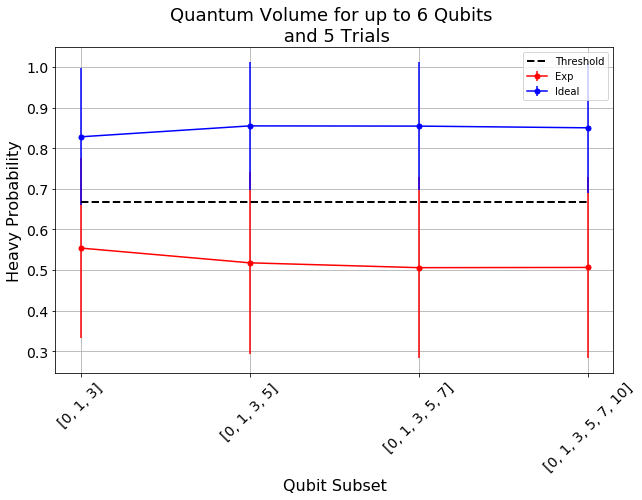

In [35]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title('Quantum Volume for up to %d Qubits \n and %d Trials'%(len(qubit_lists[-1]), ntrials), fontsize=18)

plt.show()

## Quantum Volume
List statistics for each depth. For each depth list if the depth was successful or not and with what confidence interval. For a depth to be sucessful the confidence interval must be > 97.5%.

In [36]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx]>2/3:
        if qv_success_list[qidx][0]:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (successful). Quantum volume %d"%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1],qv_fitter.quantum_volume()[qidx]))
        else:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (unsuccessful)."%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1]))
    else:
        print("Width/depth %d less than 2/3 (unsuccessful)."%len(qubit_list))

Width/depth 3 less than 2/3 (unsuccessful).
Width/depth 4 less than 2/3 (unsuccessful).
Width/depth 5 less than 2/3 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).


In [37]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright